In [18]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt


In [6]:
srepi_solar = pd.read_parquet("../data/processed/solar_srepi.parquet")

In [7]:
dir_sfcwind = Path("../data/processed/wind_srepi")
files_sfcwind = list(dir_sfcwind.glob("*"))
dict_wind = {file.stem: pd.read_parquet(file) for file in files_sfcwind}

In [9]:
srepi_solar_24 = srepi_solar[srepi_solar['window']=='24h']

In [11]:
df_drought_solar = pd.read_parquet("../data/curated/solar_drought_events.parquet")
df_drought_wind = pd.read_parquet("../data/curated/wind_drought_events.parquet")

In [ ]:

def _overlap_join_one_group(solar_g: pd.DataFrame, wind_g: pd.DataFrame) -> pd.DataFrame:
    if solar_g.empty or wind_g.empty:
        return pd.DataFrame()

    s = solar_g.sort_values("start_time").copy()
    w = wind_g.sort_values("start_time").copy()

    s_st = s["start_time"].to_numpy()
    s_et = s["end_time"].to_numpy()
    w_st = w["start_time"].to_numpy()
    w_et = w["end_time"].to_numpy()

    s_idx = s.index.to_numpy()
    w_idx = w.index.to_numpy()

    out = []
    j = 0
    m = len(w_st)

    for i in range(len(s_st)):
        while j < m and w_et[j] < s_st[i]:
            j += 1

        k = j
        while k < m and w_st[k] <= s_et[i]:
            joint_start = max(s_st[i], w_st[k])
            joint_end = min(s_et[i], w_et[k])
            if joint_start <= joint_end:
                out.append((s_idx[i], w_idx[k], joint_start, joint_end))
            k += 1

    if not out:
        return pd.DataFrame()

    df = pd.DataFrame(out, columns=["solar_event_idx", "wind_event_idx", "joint_start", "joint_end"])
    df["joint_duration_hours"] = (df["joint_end"] - df["joint_start"]).dt.total_seconds() / 3600.0
    return df


def build_joint_drought_events(
    df_drought_solar: pd.DataFrame,
    df_drought_wind: pd.DataFrame,
    require_same_asset: bool = True,
) -> pd.DataFrame:

    solar = df_drought_solar.copy()
    wind = df_drought_wind.copy()

    solar = solar.rename(columns={"code": "asset"})
    wind = wind.rename(columns={"site": "asset"})

    solar["start_time"] = pd.to_datetime(solar["start_time"])
    solar["end_time"] = pd.to_datetime(solar["end_time"])
    wind["start_time"] = pd.to_datetime(wind["start_time"])
    wind["end_time"] = pd.to_datetime(wind["end_time"])

    solar = solar[solar["end_time"] >= solar["start_time"]].copy()
    wind = wind[wind["end_time"] >= wind["start_time"]].copy()

    if require_same_asset and ("asset" in solar.columns) and ("asset" in wind.columns):
        group_cols = ["window", "asset"]
    else:
        group_cols = ["window"]  

    results = []
    solar_groups = dict(tuple(solar.groupby(group_cols, sort=False)))
    wind_groups = dict(tuple(wind.groupby(group_cols, sort=False)))

    common_keys = solar_groups.keys() & wind_groups.keys()
    for key in common_keys:
        s_g = solar_groups[key]
        w_g = wind_groups[key]
        df_o = _overlap_join_one_group(s_g, w_g)
        if df_o.empty:
            continue

        if isinstance(key, tuple):
            for col, val in zip(group_cols, key):
                df_o[col] = val
        else:
            df_o[group_cols[0]] = key

        results.append(df_o)

    if not results:
        return pd.DataFrame(columns=group_cols + ["solar_event_idx", "wind_event_idx", "joint_start", "joint_end", "joint_duration_hours"])

    df_joint_pairs = pd.concat(results, ignore_index=True)

    df_joint_pairs["joint_pair_id"] = np.arange(len(df_joint_pairs))

    return df_joint_pairs


df_joint_pairs = build_joint_drought_events(df_drought_solar, df_drought_wind, require_same_asset=True)

print("joint pairs:", len(df_joint_pairs))
df_joint_pairs.head()


joint pairs: 2334


,solar_event_idx,wind_event_idx,joint_start,joint_end,joint_duration_hours,window,asset,joint_pair_id
0,195056,384513,2014-03-28 05:30:00,2014-03-28 06:30:00,1.0,24h,GULLRGWF,0
1,195057,384513,2014-03-28 22:30:00,2014-03-29 02:30:00,4.0,24h,GULLRGWF,1
2,195058,384513,2014-03-29 21:30:00,2014-03-29 23:30:00,2.0,24h,GULLRGWF,2
3,195069,384524,2014-06-01 23:30:00,2014-06-02 01:30:00,2.0,24h,GULLRGWF,3
4,195070,384524,2014-06-02 03:30:00,2014-06-02 04:00:00,0.5,24h,GULLRGWF,4


In [ ]:
def merge_intervals(df: pd.DataFrame, group_cols, gap_hours: float = 0.0):
    if df.empty:
        return df

    d = df.copy()
    d = d.sort_values(group_cols + ["joint_start", "joint_end"]).reset_index(drop=True)

    gap = pd.Timedelta(hours=float(gap_hours))
    out = []

    for key, g in d.groupby(group_cols, sort=False):
        if not isinstance(key, tuple):
            key = (key,)

        starts = g["joint_start"].to_numpy()
        ends = g["joint_end"].to_numpy()

        cur_s = starts[0]
        cur_e = ends[0]

        for i in range(1, len(g)):
            if starts[i] <= cur_e + gap:
                cur_e = max(cur_e, ends[i])
            else:
                out.append((*key, cur_s, cur_e))
                cur_s, cur_e = starts[i], ends[i]

        out.append((*key, cur_s, cur_e))

    df_joint = pd.DataFrame(
        out,
        columns=list(group_cols) + ["joint_start", "joint_end"]
    )

    df_joint["joint_duration_hours"] = (
        df_joint["joint_end"] - df_joint["joint_start"]
    ).dt.total_seconds() / 3600.0

    df_joint["joint_event_id"] = range(len(df_joint))

    return df_joint


In [ ]:
group_cols = ["window", "asset"]

df_joint_events = merge_intervals(
    df_joint_pairs,
    group_cols=group_cols,
    gap_hours=0.0 
)

df_joint_events


,window,asset,joint_start,joint_end,joint_duration_hours,joint_event_id
0,120h,GULLRGWF,2014-06-08 01:00:00,2014-06-08 05:30:00,4.5,0
1,120h,GULLRGWF,2014-06-09 00:30:00,2014-06-09 04:30:00,4.0,1
2,120h,GULLRGWF,2014-06-11 23:30:00,2014-06-12 01:00:00,1.5,2
3,120h,GULLRGWF,2014-06-15 02:30:00,2014-06-15 05:30:00,3.0,3
4,120h,GULLRGWF,2014-06-22 03:00:00,2014-06-22 05:30:00,2.5,4
...,...,...,...,...,...,...
2329,72h,PAREPW,2023-07-03 00:30:00,2023-07-03 06:30:00,6.0,2329
2330,72h,PAREPW,2023-07-03 23:30:00,2023-07-04 06:30:00,7.0,2330
2331,72h,PAREPW,2023-07-11 04:00:00,2023-07-11 06:30:00,2.5,2331
2332,72h,PAREPW,2023-07-11 23:30:00,2023-07-12 06:30:00,7.0,2332


C:\Users\HKlll\AppData\Local\Temp\ipykernel_9612\3659447687.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_solar = df_drought_solar.groupby("window").size().reindex(WINDOWS).fillna(0)
C:\Users\HKlll\AppData\Local\Temp\ipykernel_9612\3659447687.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_wind  = df_drought_wind.groupby("window").size().reindex(WINDOWS).fillna(0)
C:\Users\HKlll\AppData\Local\Temp\ipykernel_9612\3659447687.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

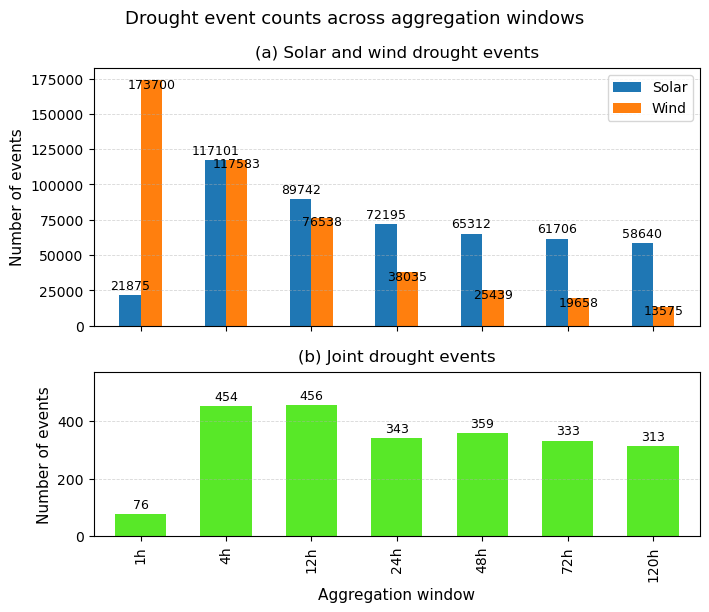

In [ ]:

WINDOWS = ["1h","4h","12h","24h","48h","72h","120h"]

for df in [df_drought_solar, df_drought_wind, df_joint_events]:
    df["window"] = pd.Categorical(df["window"], categories=WINDOWS, ordered=True)

count_solar = df_drought_solar.groupby("window").size().reindex(WINDOWS).fillna(0)
count_wind  = df_drought_wind.groupby("window").size().reindex(WINDOWS).fillna(0)
count_joint = df_joint_events.groupby("window").size().reindex(WINDOWS).fillna(0)


fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(7.2, 6.2),
    sharex=True,
    gridspec_kw={"height_ratios": [2.2, 1.4]}
)

df_big = pd.DataFrame({"Solar": count_solar, "Wind": count_wind})
df_big.plot(kind="bar", ax=ax1)

ax1.set_ylabel("Number of events", fontsize=11)
ax1.set_title("(a) Solar and wind drought events", fontsize=12, pad=8)
ax1.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax1.xaxis.grid(False)

for i, container in enumerate(ax1.containers):
    ax1.bar_label(
        container,
        fmt="%.0f",
        padding=2 - i * 10,  
        fontsize=9
    )

df_joint = pd.DataFrame({"Joint": count_joint})
df_joint.plot(
    kind="bar",
    ax=ax2,
    legend=False,
    color="#58E828", 
    width=0.6
)
ax2.set_xlabel("Aggregation window", fontsize=11)
ax2.set_ylabel("Number of events", fontsize=11)
ax2.set_title("(b) Joint drought events", fontsize=12, pad=8)
ax2.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax2.xaxis.grid(False)

ymax = np.max(count_joint.values) if len(count_joint) else 1
ax2.set_ylim(0, ymax * 1.25 if ymax > 0 else 1)

for container in ax2.containers:
    ax2.bar_label(container, fmt="%.0f", padding=2, fontsize=9)

fig.suptitle("Drought event counts across aggregation windows", fontsize=13, y=0.98)

plt.tight_layout()

plt.savefig("../figures/fig_sw_by_window.png", dpi=300, bbox_inches="tight", facecolor="white")

plt.show()



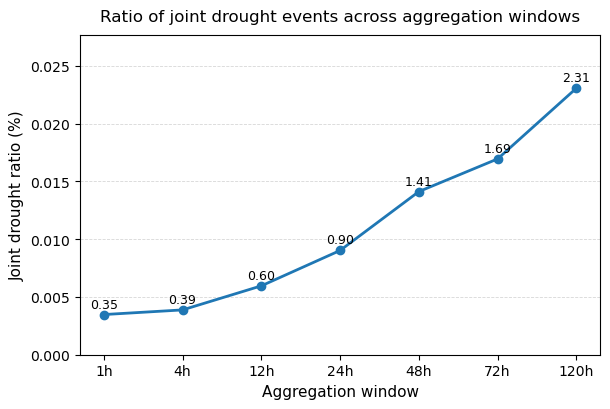

In [56]:

y = df_ratio.values
y_max = np.nanmax(y)

fig, ax = plt.subplots(figsize=(6.2, 4.2))

ax.plot(
    df_ratio.index,
    y,
    marker="o",
    linewidth=2.0,
    markersize=6
)

for x, val in zip(df_ratio.index, y):
    ax.text(
        x,
        val + 0.015 * y_max,
        f"{val*100:.2f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

ax.set_xlabel("Aggregation window", fontsize=11)
ax.set_ylabel("Joint drought ratio (%)", fontsize=11)

ax.set_title(
    "Ratio of joint drought events across aggregation windows",
    fontsize=12,
    pad=10
)

ax.set_ylim(0, y_max * 1.2)

ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax.xaxis.grid(False)

plt.tight_layout()

plt.savefig(
    "../figures/fig_sw_joint_ratio.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)


plt.show()



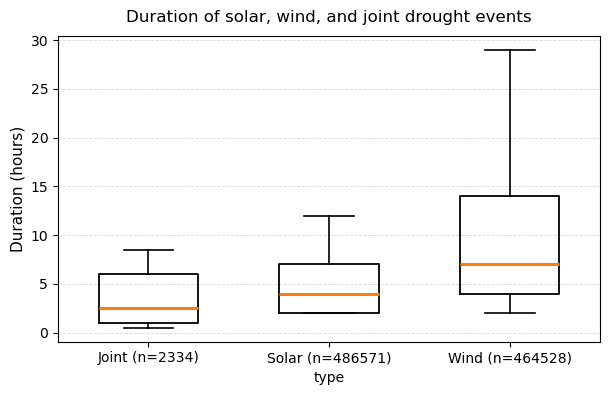

In [57]:

fig, ax = plt.subplots(figsize=(6.2, 4.2))

df_duration.boxplot(
    column="duration_hours",
    by="type",
    showfliers=False,
    widths=0.55,
    patch_artist=False,
    medianprops=dict(linewidth=2.2),
    boxprops=dict(linewidth=1.3),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    ax=ax
)

ax.set_xticklabels(
    [f"{t} (n={counts[t]})" for t in counts.index],
    fontsize=10
)

# y 轴
ax.set_ylabel("Duration (hours)", fontsize=11)

ax.set_title(
    "Duration of solar, wind, and joint drought events",
    fontsize=12,
    pad=10
)

ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax.xaxis.grid(False)

plt.suptitle("")

plt.tight_layout()

plt.savefig(
    "../figures/fig_sw_joint_box.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)


plt.show()
